In [1]:
"""
Learning growth constants model
===============================

In this example we will learn a growth constants model from a leaf that follows a
basipetal growth pattern.

"""

###############################################################################
# We first import what we need.
#

import sys
sys.path.append("../../")

import math
import pickle
import copy

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

###############################################################################
# We load the data, rescale it and zero it.
#
# In order to get more information, we also load the points.
#

In [45]:
data = pickle.load(open("../../data/basipetal.pkl", 'rb'))

height_source = 38.
height_target = 100.

dots_source = torch.tensor(data['source_d'], dtype=torch.get_default_dtype())
dots_target = torch.tensor(data['target_d'], dtype=torch.get_default_dtype())
shape_source = torch.tensor(data['source_c'], dtype=torch.get_default_dtype())
shape_target = torch.tensor(data['target_c'], dtype=torch.get_default_dtype())

smin, smax = torch.min(shape_source[:, 1]), torch.max(shape_source[:, 1])
sscale = height_source / (smax - smin)
dots_source[:, 1] =  sscale * (dots_source[:, 1] - smax)
dots_source[:, 0] = sscale * (dots_source[:, 0] - torch.mean(shape_source[:, 0]))
shape_source[:, 1] =  sscale * (shape_source[:, 1] - smax)
shape_source[:, 0] = sscale * (shape_source[:, 0] - torch.mean(shape_source[:, 0]))

tmin, tmax = torch.min(shape_target[:, 1]), torch.max(shape_target[:, 1])
tscale = height_target / (tmax - tmin)
dots_target[:, 1] =  tscale * (dots_target[:, 1] - tmax)
dots_target[:, 0] = tscale * (dots_target[:, 0] - torch.mean(shape_target[:, 0]))
shape_target[:, 1] =  tscale * (shape_target[:, 1] - tmax)
shape_target[:, 0] = tscale * (shape_target[:, 0] - torch.mean(shape_target[:, 0]))

# We only have dot data for one side of the leaf
#shape_source = shape_source[shape_source[:, 0] <= 0]
#shape_target = shape_target[shape_target[:, 0] <= 0]

In [46]:
###############################################################################
# We now sample the points that will be used by the deformation modules.
#

# Build AABB around the source shape and uniformly sample points for the implicit
# module of order 1
aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

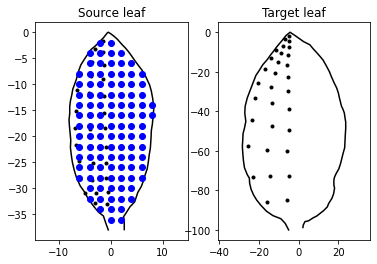

In [47]:
###############################################################################
# Plot everything.
#

plt.subplot(1, 2, 1)
plt.title("Source leaf")
plt.plot(dots_source[:, 0].numpy(), dots_source[:, 1].numpy(), '.', color='black')
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), color='black')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), 'o', color='blue')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Target leaf")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), color='black')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), '.', color='black')
plt.axis('equal')

plt.show()

In [48]:
###############################################################################
# We now build the implicit module that will model the growth.
#
# Since we will be learning its growth constants, we need to set its
# `requires_grad` flag to `True`.
#

nu = 0.001
coeff_growth = 1.
scale_growth = 25.

global_translation = dm.DeformationModules.GlobalTranslation(2)

C = torch.ones(points_growth.shape[0], 2, 1)

growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth.clone().requires_grad_(),
        rot_growth.clone().requires_grad_()))

In [6]:
###############################################################################
# Quadratic model for the growing constants.
#

# The polynomial model we will try to fit on our deformation constants
def pol_order_2(pos, a, b, c, d, e, f):
    return a + b*pos[:, 0] + c*pos[:, 1] + d*pos[:, 0]**2 + e*pos[:, 1]**2 + f*pos[:, 0]*pos[:, 1]
def pol_order_2_fromabc(pos, abc):
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    e = abc[4].unsqueeze(1)
    f = abc[5].unsqueeze(1)
    return a + b*pos[:, 0] + c*pos[:, 1] + d*pos[:, 0]**2 + e*pos[:, 1]**2 + f*pos[:, 0]*pos[:, 1]

# Initial parameters of our model
abc = torch.zeros(6, 2)
abc[0] = torch.ones(2)
initial_abc = abc.clone().detach()
abc.requires_grad_()

# Callback called when evaluating the model.
# Serves as glue for our model of deformation constants.
def callback_compute_c(init_manifold, modules, parameters):
    abc = parameters['abc']['params'][0]
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    e = abc[4].unsqueeze(1)
    f = abc[5].unsqueeze(1)
    modules[3]._ImplicitModule1Base__C = pol_order_2(
        init_manifold[3].gd[0], a, b, c, d, e, f).transpose(0, 1).unsqueeze(2)

In [49]:
# The polynomial model we will try to fit on our deformation constants, 
# Here we assume that the growth parameters only depends on the vertical axis
def pol_order_2(pos, a, c, e):
    return a + c*pos[:, 1] + e*pos[:, 1]**2 
def pol_order_2_fromabc(pos, abc):
    a = abc[0].unsqueeze(1)
    c = abc[1].unsqueeze(1)
    e = abc[2].unsqueeze(1)
    return a + c*pos[:, 1] + e*pos[:, 1]**2 

# Initial parameters of our model
abc = -1. + 2*torch.rand(3, 2)
#abc = torch.zeros(6, 2)
#abc[0] = torch.ones(2)
initial_abc = abc.clone().detach()
abc.requires_grad_()

# Callback called when evaluating the model.
# Serves as glue for our model of deformation constants.
def callback_compute_c(init_manifold, modules, parameters):
    abc = parameters['abc']['params'][0]
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    modules[3]._ImplicitModule1Base__C = pol_order_2(
        init_manifold[3].gd[0], a, b, c).transpose(0, 1).unsqueeze(2)

In [50]:
print(initial_abc)

tensor([[-0.6465,  0.0281],
        [-0.8098, -0.8367],
        [-0.5113,  0.7962]])


In [51]:
deformable_shape_source = dm.Models.DeformablePoints(shape_source)
deformable_shape_target = dm.Models.DeformablePoints(shape_target)
deformable_dots_source = dm.Models.DeformablePoints(dots_source)
deformable_dots_target = dm.Models.DeformablePoints(dots_target)


In [52]:
###############################################################################
# We now define the model. We set the model parameters as an other parameter
# so that it also get learned.
#

model = dm.Models.RegistrationModel([deformable_shape_source, deformable_dots_source], [global_translation, growth], [dm.Attachment.VarifoldAttachment(2, [5., 25, 80.]), dm.Attachment.EuclideanPointwiseDistanceAttachment(500.)], lam=100., other_parameters={'abc': {'params': [abc]}}, precompute_callback=callback_compute_c)

In [53]:
###############################################################################
# Fitting.
#

shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
fitter.fit([deformable_shape_target, deformable_dots_target], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 38.612826749000305
Iteration: 0
Costs
deformation=17911.84375
attach=7105506.0
Total cost=7123417.84375
Time: 76.59528363000027
Iteration: 1
Costs
deformation=32331.40625
attach=4717779.5
Total cost=4750110.90625
Time: 96.32887102600034
Iteration: 2
Costs
deformation=32878.34765625
attach=4711363.5
Total cost=4744241.84765625
Time: 106.95010204000027
Iteration: 3
Costs
deformation=32878.34765625
attach=4711363.5
Total cost=4744241.84765625
Optimisation process exited with message: Convergence achieved.
Final cost=4744241.84765625
Model evaluation count=71
Time elapsed = 106.95023124099953


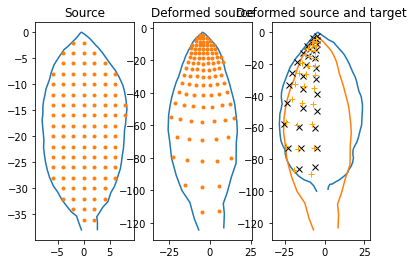

In [54]:


###############################################################################
# Plot matching results.
#

intermediates = {}
model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_sourcedots = intermediate_states[-1][1].gd
deformed_growth = intermediate_states[-1][3].gd[0]
deformed_growth_rot = intermediate_states[-1][3].gd[1]

aabb_target = dm.Utilities.AABB.build_from_points(shape_target).squared().scale(1.1)

plt.subplot(1, 3, 1)
plt.title("Source")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '-')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_growth[:, 0], deformed_growth[:, 1], '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), 'x', color='black')
plt.plot(deformed_sourcedots[:, 0].numpy(), deformed_sourcedots[:, 1].numpy(), '+', color='orange')
plt.axis(aabb_target.totuple())


plt.axis('equal')
plt.show()



Initial growth constants model parameters:
tensor([[-0.6465,  0.0281],
        [-0.8098, -0.8367],
        [-0.5113,  0.7962]])
Learned growth constants model parameters:
tensor([[  -0.7439,   -0.5971],
        [   2.2026,    9.8829],
        [-118.5648, -160.7611]])


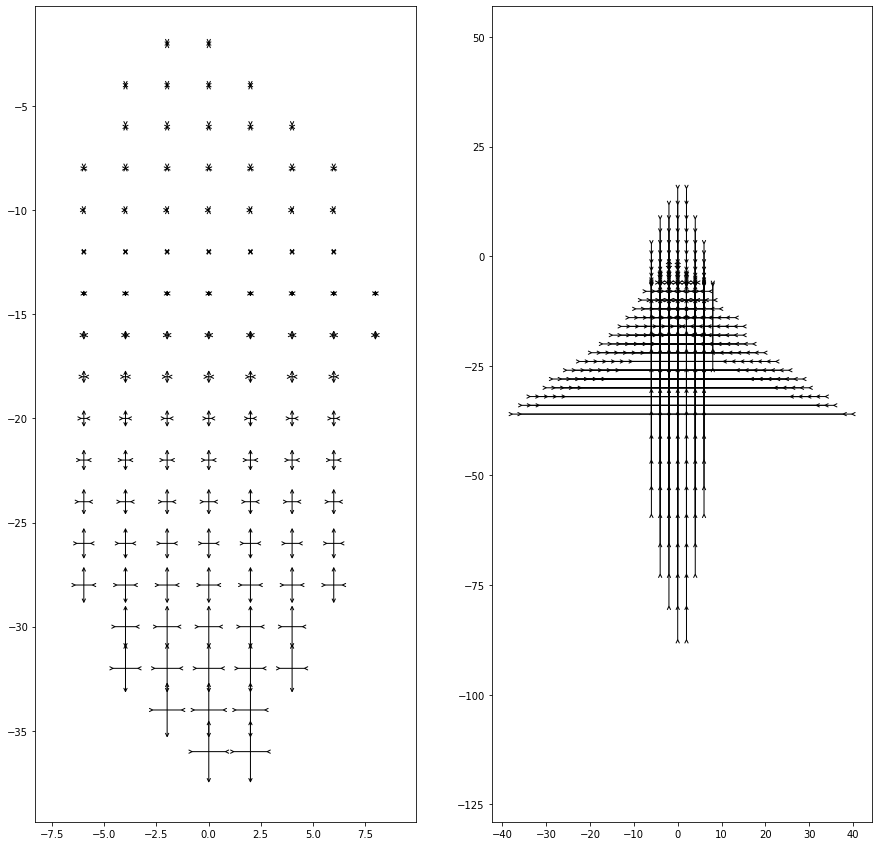

In [55]:

###############################################################################
# Evaluate and plot learned growth constants. We see more growth at the basis
# than at the apex: this is basipetal growth.
#

init_growth = intermediate_states[0][3].gd[0]
init_growth_rot = intermediate_states[0][3].gd[1]


initial_C = pol_order_2_fromabc(init_growth.detach(),
                        initial_abc).transpose(0, 1).unsqueeze(2)

print("Initial growth constants model parameters:")
print(initial_abc)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(1,2,1)
dm.Utilities.plot_C_arrows(ax, init_growth, initial_C, R=init_growth_rot, scale=0.003, mutation_scale=8.)
#plt.plot(init_growth.detach().numpy()[:,0], init_growth.detach().numpy()[:,1], '.')
#dm.Utilities.plot_C_ellipses(ax, init_growth, initial_C, R=init_growth_rot, scale=0.003)

#plt.axis(aabb_source.squared().totuple())
plt.axis('equal')


init_growth = intermediate_states[0][3].gd[0]
init_growth_rot = intermediate_states[0][3].gd[1]
learned_abc = abc.detach()
learned_C = pol_order_2_fromabc(init_growth.detach(),
                        learned_abc).transpose(0, 1).unsqueeze(2)

print("Learned growth constants model parameters:")
print(learned_abc)

ax2 = f.add_subplot(1,2,2)
dm.Utilities.plot_C_arrows(ax2, init_growth, learned_C, R=init_growth_rot, scale=0.0005, mutation_scale=8.)
#plt.plot(init_growth.detach().numpy()[:,0], init_growth.detach().numpy()[:,1], '.')
#dm.Utilities.plot_C_ellipses(ax2, init_growth, learned_C, R=init_growth_rot, scale=0.0005)
#plt.axis(aabb_source.squared().totuple())
plt.axis('equal')
plt.show()



In [56]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)


Initial growth constants model parameters:
tensor([[-0.6465,  0.0281],
        [-0.8098, -0.8367],
        [-0.5113,  0.7962]])
Learned growth constants model parameters:
tensor([[  -0.7439,   -0.5971],
        [   2.2026,    9.8829],
        [-118.5648, -160.7611]])


In [66]:
learned_C2 = pol_order_2_fromabc(model.init_manifold.manifolds[3].gd[0], learned_abc).transpose(0, 1).unsqueeze(2)

In [67]:
learned_C2 - learned_C

tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        

In [57]:
C_normalized = learned_C/torch.norm(learned_C)

In [40]:
C_save_normalized = learned_C_save/torch.norm(learned_C_save)

In [61]:
abs(torch.sum(C_normalized*C_save_normalized)) - 1

tensor(-0.0249)

In [44]:
C_normalized - C_save_normalized

tensor([[[-0.0074],
         [ 0.0124]],

        [[-0.0118],
         [ 0.0069]],

        [[-0.0155],
         [ 0.0020]],

        [[-0.0184],
         [-0.0021]],

        [[-0.0206],
         [-0.0054]],

        [[-0.0219],
         [-0.0081]],

        [[-0.0226],
         [-0.0101]],

        [[-0.0224],
         [-0.0113]],

        [[-0.0215],
         [-0.0119]],

        [[-0.0198],
         [-0.0117]],

        [[-0.0174],
         [-0.0108]],

        [[ 0.0038],
         [ 0.0256]],

        [[-0.0022],
         [ 0.0187]],

        [[-0.0074],
         [ 0.0124]],

        [[-0.0118],
         [ 0.0069]],

        [[-0.0155],
         [ 0.0020]],

        [[-0.0184],
         [-0.0021]],

        [[-0.0206],
         [-0.0054]],

        [[-0.0219],
         [-0.0081]],

        [[-0.0226],
         [-0.0101]],

        [[-0.0224],
         [-0.0113]],

        [[-0.0215],
         [-0.0119]],

        [[-0.0198],
         [-0.0117]],

        [[-0.0174],
         [-0.0

In [68]:
n_exp = 100
diffs = []
initial_abcs = []
learned_abcs = []
for i_exp in range(n_exp):
    data = pickle.load(open("../../data/basipetal.pkl", 'rb'))

    height_source = 38.
    height_target = 100.

    dots_source = torch.tensor(data['source_d'], dtype=torch.get_default_dtype())
    dots_target = torch.tensor(data['target_d'], dtype=torch.get_default_dtype())
    shape_source = torch.tensor(data['source_c'], dtype=torch.get_default_dtype())
    shape_target = torch.tensor(data['target_c'], dtype=torch.get_default_dtype())

    smin, smax = torch.min(shape_source[:, 1]), torch.max(shape_source[:, 1])
    sscale = height_source / (smax - smin)
    dots_source[:, 1] =  sscale * (dots_source[:, 1] - smax)
    dots_source[:, 0] = sscale * (dots_source[:, 0] - torch.mean(shape_source[:, 0]))
    shape_source[:, 1] =  sscale * (shape_source[:, 1] - smax)
    shape_source[:, 0] = sscale * (shape_source[:, 0] - torch.mean(shape_source[:, 0]))

    tmin, tmax = torch.min(shape_target[:, 1]), torch.max(shape_target[:, 1])
    tscale = height_target / (tmax - tmin)
    dots_target[:, 1] =  tscale * (dots_target[:, 1] - tmax)
    dots_target[:, 0] = tscale * (dots_target[:, 0] - torch.mean(shape_target[:, 0]))
    shape_target[:, 1] =  tscale * (shape_target[:, 1] - tmax)
    shape_target[:, 0] = tscale * (shape_target[:, 0] - torch.mean(shape_target[:, 0]))

    ###############################################################################
    # We now sample the points that will be used by the deformation modules.
    #

    # Build AABB around the source shape and uniformly sample points for the implicit
    # module of order 1
    aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
    points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

    rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

    ###############################################################################
    # We now build the implicit module that will model the growth.
    #
    # Since we will be learning its growth constants, we need to set its
    # `requires_grad` flag to `True`.
    #

    nu = 0.001
    coeff_growth = 1.
    scale_growth = 25.

    global_translation = dm.DeformationModules.GlobalTranslation(2)

    C = torch.ones(points_growth.shape[0], 2, 1)

    growth = dm.DeformationModules.ImplicitModule1(
        2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
        gd=(points_growth.clone().requires_grad_(),
            rot_growth.clone().requires_grad_()))
    # The polynomial model we will try to fit on our deformation constants, 
    # Here we assume that the growth parameters only depends on the vertical axis
    def pol_order_2(pos, a, c, e):
        return a + c*pos[:, 1] + e*pos[:, 1]**2 
    def pol_order_2_fromabc(pos, abc):
        a = abc[0].unsqueeze(1)
        c = abc[1].unsqueeze(1)
        e = abc[2].unsqueeze(1)
        return a + c*pos[:, 1] + e*pos[:, 1]**2 

    # Initial parameters of our model
    abc = -1. + 2*torch.rand(3, 2)
    #abc = torch.zeros(6, 2)
    #abc[0] = torch.ones(2)
    initial_abcs.append(abc.clone().detach())
    abc.requires_grad_()

    # Callback called when evaluating the model.
    # Serves as glue for our model of deformation constants.
    def callback_compute_c(init_manifold, modules, parameters):
        abc = parameters['abc']['params'][0]
        a = abc[0].unsqueeze(1)
        b = abc[1].unsqueeze(1)
        c = abc[2].unsqueeze(1)
        modules[3]._ImplicitModule1Base__C = pol_order_2(
            init_manifold[3].gd[0], a, b, c).transpose(0, 1).unsqueeze(2)

    deformable_shape_source = dm.Models.DeformablePoints(shape_source)
    deformable_shape_target = dm.Models.DeformablePoints(shape_target)
    deformable_dots_source = dm.Models.DeformablePoints(dots_source)
    deformable_dots_target = dm.Models.DeformablePoints(dots_target)
    ###############################################################################
    # We now define the model. We set the model parameters as an other parameter
    # so that it also get learned.
    #

    model = dm.Models.RegistrationModel([deformable_shape_source, deformable_dots_source], [global_translation, growth], [dm.Attachment.VarifoldAttachment(2, [5., 25, 80.]), dm.Attachment.EuclideanPointwiseDistanceAttachment(500.)], lam=100., other_parameters={'abc': {'params': [abc]}}, precompute_callback=callback_compute_c)

    shoot_solver = 'euler'
    shoot_it = 10

    costs = {}
    fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
    fitter.fit([deformable_shape_target, deformable_dots_target], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

    learned_abc = abc.detach()
    learned_abcs.append(learned_abc.clone().detach())
    learned_C = pol_order_2_fromabc(model.init_manifold.manifolds[3].gd[0], learned_abc).transpose(0, 1).unsqueeze(2)
    C_normalized = learned_C/torch.norm(learned_C)
    diffs.append(abs(torch.sum(C_normalized*C_save_normalized)) - 1)
    print('------------------' + str(i_exp) + '------' + str(abs(torch.sum(C_normalized*C_save_normalized)) - 1))

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 34.87366556300003
Iteration: 0
Costs
deformation=16124.1513671875
attach=6997319.5
Total cost=7013443.6513671875
Time: 72.70214819699959
Iteration: 1
Costs
deformation=29263.853515625
attach=4811193.0
Total cost=4840456.853515625
Time: 101.25384656099959
Iteration: 2
Costs
deformation=31341.826171875
attach=4711328.0
Total cost=4742669.826171875
Time: 115.80598379899948
Iteration: 3
Costs
deformation=31341.826171875
attach=4711328.0
Total cost=4742669.826171875
Optimisation process exited with message: Convergence achieved.
Final cost=4742669.826171875
Model evaluation count=77
Time elapsed = 115.80615496599967
------------------0------tensor(-0.0248, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 47.15378070999941
Iteration: 0
Costs
deformation=21445.138671875
attach=

Time: 229.6885360619999
Iteration: 5
Costs
deformation=2940.9462890625
attach=1612647.5
Total cost=1615588.4462890625
Time: 240.06368844999997
Iteration: 6
Costs
deformation=2940.9462890625
attach=1612647.5
Total cost=1615588.4462890625
Optimisation process exited with message: Convergence achieved.
Final cost=1615588.4462890625
Model evaluation count=144
Time elapsed = 240.06382803899942
------------------4------tensor(-0.0021, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 40.65680139699907
Iteration: 0
Costs
deformation=17229.0546875
attach=8035299.0
Total cost=8052528.0546875
Time: 81.45250755799862
Iteration: 1
Costs
deformation=27788.857421875
attach=4697810.0
Total cost=4725598.857421875
Time: 122.12170675799825
Iteration: 2
Costs
deformation=13615.7763671875
attach=3516312.5
Total cost=3529928.2763671875
Time: 163.6983334969991
Iteration: 3
Costs
deformation=6691.01416015625
attac

Time: 41.55178369100031
Iteration: 0
Costs
deformation=40960.80078125
attach=5968086.5
Total cost=6009047.30078125
Time: 95.72864216000016
Iteration: 1
Costs
deformation=32335.033203125
attach=4709935.5
Total cost=4742270.533203125
Time: 111.1310725530002
Iteration: 2
Costs
deformation=32335.033203125
attach=4709935.5
Total cost=4742270.533203125
Optimisation process exited with message: Convergence achieved.
Final cost=4742270.533203125
Model evaluation count=66
Time elapsed = 111.13121287099966
------------------10------tensor(-0.0248, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 45.26446440699874
Iteration: 0
Costs
deformation=9150.59375
attach=19858396.0
Total cost=19867546.59375
Time: 80.68894172999899
Iteration: 1
Costs
deformation=31210.771484375
attach=4688153.0
Total cost=4719363.771484375
Time: 92.89916729699871
Iteration: 2
Costs
deformation=31210.771484375
attach=4688153.0
T

Time: 234.66649306400177
Iteration: 5
Costs
deformation=2678.065185546875
attach=1612779.125
Total cost=1615457.1901855469
Time: 243.1400417040004
Iteration: 6
Costs
deformation=2678.065185546875
attach=1612779.125
Total cost=1615457.1901855469
Optimisation process exited with message: Convergence achieved.
Final cost=1615457.1901855469
Model evaluation count=142
Time elapsed = 243.14017691500158
------------------15------tensor(-0.0021, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 40.71802648099947
Iteration: 0
Costs
deformation=44620.56640625
attach=14893692.0
Total cost=14938312.56640625
Time: 84.04621449600018
Iteration: 1
Costs
deformation=28093.36328125
attach=4632634.5
Total cost=4660727.86328125
Time: 127.30513566899936
Iteration: 2
Costs
deformation=5276.97900390625
attach=3914874.25
Total cost=3920151.2290039062
Time: 170.32942319500035
Iteration: 3
Costs
deformation=6024.7158

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 39.86336217000098
Iteration: 0
Costs
deformation=15603.9130859375
attach=21481150.0
Total cost=21496753.913085938
Time: 81.91035687800104
Iteration: 1
Costs
deformation=31304.740234375
attach=4606194.5
Total cost=4637499.240234375
Time: 123.73171938999985
Iteration: 2
Costs
deformation=29011.421875
attach=4479635.5
Total cost=4508646.921875
Time: 165.33348000600017
Iteration: 3
Costs
deformation=13172.888671875
attach=3049109.0
Total cost=3062281.888671875
Time: 206.26858054600052
Iteration: 4
Costs
deformation=7908.93798828125
attach=1769410.375
Total cost=1777319.3129882812
Time: 239.2731613370015
Iteration: 5
Costs
deformation=7635.52978515625
attach=1612255.625
Total cost=1619891.1547851562
Time: 247.32069303400021
Iteration: 6
Costs
deformation=7635.52978515625
attach=1612255.625
Total cost=1619891.1547851562
Optimisation process exited with message: Convergenc

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 43.76737667999987
Iteration: 0
Costs
deformation=20295.537109375
attach=7108082.0
Total cost=7128377.537109375
Time: 84.37442615600048
Iteration: 1
Costs
deformation=32055.310546875
attach=4707846.0
Total cost=4739901.310546875
Time: 110.31763986100123
Iteration: 2
Costs
deformation=32046.03515625
attach=4707759.5
Total cost=4739805.53515625
Time: 122.04651510199983
Iteration: 3
Costs
deformation=32046.03515625
attach=4707759.5
Total cost=4739805.53515625
Optimisation process exited with message: Convergence achieved.
Final cost=4739805.53515625
Model evaluation count=72
Time elapsed = 122.04664856300042
------------------26------tensor(-0.0248, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 41.299360376999175
Iteration: 0
Costs
deformation=31239.796875
attach=6373969.

Time: 137.6831275270015
Iteration: 2
Costs
deformation=17991.029296875
attach=4587758.5
Total cost=4605749.529296875
Time: 184.9884617610005
Iteration: 3
Costs
deformation=5584.9951171875
attach=3047371.5
Total cost=3052956.4951171875
Time: 228.84962180500042
Iteration: 4
Costs
deformation=2777.9248046875
attach=2493971.0
Total cost=2496748.9248046875
Time: 271.6016970700002
Iteration: 5
Costs
deformation=3129.908203125
attach=1612819.375
Total cost=1615949.283203125
Time: 287.3555809370009
Iteration: 6
Costs
deformation=3122.01806640625
attach=1612698.875
Total cost=1615820.8930664062
Time: 296.04475537100006
Iteration: 7
Costs
deformation=3122.01806640625
attach=1612698.875
Total cost=1615820.8930664062
Optimisation process exited with message: Convergence achieved.
Final cost=1615820.8930664062
Model evaluation count=175
Time elapsed = 296.04494764300034
------------------32------tensor(-0.0021, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'def

Time: 45.196038606
Iteration: 0
Costs
deformation=28041.298828125
attach=11237309.0
Total cost=11265350.298828125
Time: 89.46703795099893
Iteration: 1
Costs
deformation=34298.421875
attach=4847933.0
Total cost=4882231.421875
Time: 127.24775350099844
Iteration: 2
Costs
deformation=26753.07421875
attach=4603687.0
Total cost=4630440.07421875
Time: 154.3395819519992
Iteration: 3
Costs
deformation=3632.697998046875
attach=4593970.0
Total cost=4597602.697998047
Time: 164.71740693099855
Iteration: 4
Costs
deformation=3632.697998046875
attach=4593970.0
Total cost=4597602.697998047
Optimisation process exited with message: Convergence achieved.
Final cost=4597602.697998047
Model evaluation count=92
Time elapsed = 164.71754323099958
------------------38------tensor(-0.0212, grad_fn=<SubBackward0>)
Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 77.40498776700042
Iteration: 0
Costs
deformation=nan
attach=nan
Total cost=nan


KeyboardInterrupt: 

In [80]:
C_normalized = learned_C/torch.norm(learned_C)

In [82]:
C_normalized*C_save_normalized

tensor([[[-8.1307e-03],
         [-9.9936e-03]],

        [[-7.1005e-03],
         [-8.0964e-03]],

        [[-6.1255e-03],
         [-6.4691e-03]],

        [[-5.2095e-03],
         [-5.0866e-03]],

        [[-4.3563e-03],
         [-3.9250e-03]],

        [[-3.5695e-03],
         [-2.9612e-03]],

        [[-2.8524e-03],
         [-2.1738e-03]],

        [[-2.2084e-03],
         [-1.5421e-03]],

        [[-1.6407e-03],
         [-1.0468e-03]],

        [[-1.1524e-03],
         [-6.6969e-04]],

        [[-7.4635e-04],
         [-3.9368e-04]],

        [[-1.0341e-02],
         [-1.4704e-02]],

        [[-9.2122e-03],
         [-1.2187e-02]],

        [[-8.1307e-03],
         [-9.9936e-03]],

        [[-7.1005e-03],
         [-8.0964e-03]],

        [[-6.1255e-03],
         [-6.4691e-03]],

        [[-5.2095e-03],
         [-5.0866e-03]],

        [[-4.3563e-03],
         [-3.9250e-03]],

        [[-3.5695e-03],
         [-2.9612e-03]],

        [[-2.8524e-03],
         [-2.1738e-03]],



In [71]:
print([di.item() for di in diffs])

[-0.024793505668640137, -0.024477899074554443, -0.0020981431007385254, -0.0021457672119140625, -0.002099931240081787, -0.0021022558212280273, -0.002097606658935547, -0.0021126270294189453, -0.024785876274108887, nan, -0.024847090244293213, -0.024587035179138184, -0.0021088719367980957, -0.002095341682434082, -0.0020914077758789062, -0.002096831798553467, -0.0020914077758789062, -0.002101421356201172, -0.0020992159843444824, -0.024812519550323486, -0.024890661239624023, -0.0020874738693237305, -0.0021019577980041504, -0.0021039247512817383, -0.02477043867111206, -0.002097606658935547, -0.024789392948150635, -0.002034008502960205, -0.024642884731292725, -0.02483469247817993, -0.02481299638748169, -0.024770677089691162, -0.0020974278450012207, -0.002103745937347412, -0.002110719680786133, -0.024673819541931152, nan, -0.024875104427337646, -0.021198391914367676, nan, -0.002113521099090576]


In [73]:
C_save_normalized.shape

torch.Size([105, 2, 1])

In [74]:
torch.norm(learned_C)

tensor(3131.2053, grad_fn=<NormBackward0>)

In [78]:
torch.sum(C_save_normalized**2)

tensor(1.0000)

In [19]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)

print("Learned growth parameter:")
print(learned_C_save)


Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
Learned growth constants model parameters:
tensor([[-1.5216e+00, -7.2023e-02],
        [-9.5480e+01, -6.7221e+01],
        [ 3.4804e-01,  1.7700e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])
Learned growth parameter:
tensor([[[2944.7891],
         [3269.7671]],

        [[2716.2400],
         [2944.1699]],

        [[2490.4753],
         [2632.7319]],

        [[2267.4949],
         [2335.4541]],

        [[2047.2991],
         [2052.3354]],

        [[1829.8875],
         [1783.3765]],

        [[1615.2603],
         [1528.5771]],

        [[1403.4172],
         [1287.9374]],

        [[1194.3588],
         [1061.4572]],

        [[ 988.0844],
         [ 849.1367]],

        [[ 784.5945],
         [ 650.9757]],

        [[3410.2402],
         [3963.4409]],

        [[

In [16]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)


Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.]])
Learned growth constants model parameters:
tensor([[-1.5216e+00, -7.2023e-02],
        [-9.5480e+01, -6.7221e+01],
        [ 3.4804e-01,  1.7700e+00]])
